# Learning Stable Deep Koopman Operators 


This tutorial demonstrates the use of [Deep Koopman Operators](https://www.nature.com/articles/s41467-018-07210-0) (DeepKO) with stability guarantees for system identificaiton of autonomous nonlinear dynamical systems in NeuroMANCER. 


## Koopman System Identification Problem Setup

<img src="../figs/Koopman.PNG" width="500">  

Image adopted from [2].
System observables  $x_{k}$ are encoded via encoder neural network $\phi$ to generate latent states $y_{k}$ (linear coordinates). This coordinate transformation now allos to apply linear Koopman operator $K$ on the latent states $y_{k}$ to obtain latent states at the next time step $y_{k+1}$. After the rollout over given prediction horizon $N$ the generated latent trajectories $\{y_1, ..., y_N \}$ are proejcted back to the observable space via decoder neural network $\phi^{-1}$.
In theory, the decoder $\phi^{-1}$ is an inverse of the encoder $\phi$.
Now this Koopman encoder-decoder model can be trained as any other black-box nonlinear system identification problem with the loss $\mathcal{L}$ evaluated by comparing the  trajectory generated by the model with the training trajectory. 


### Koopman References

[1] [Naoya Takeishi, Yoshinobu Kawahara, Takehisa Yairi, Learning Koopman Invariant Subspaces for Dynamic Mode Decomposition, NeurIPS 2017](https://papers.nips.cc/paper_files/paper/2017/hash/3a835d3215755c435ef4fe9965a3f2a0-Abstract.html)  
[2] [Lusch, B., Kutz, J.N. & Brunton, S.L. Deep learning for universal linear embeddings of nonlinear dynamics. Nat Commun 9, 4950 (2018).](https://www.nature.com/articles/s41467-018-07210-0)  
[3] [E. Yeung, S. Kundu and N. Hodas, "Learning Deep Neural Network Representations for Koopman Operators of Nonlinear Dynamical Systems," 2019 American Control Conference (ACC), Philadelphia, PA, USA, 2019, pp. 4832-4839](https://ieeexplore.ieee.org/document/8815339)  
[4] [Shaowu Pan, Karthik Duraisamy, Physics-Informed Probabilistic Learning of Linear Embeddings of Non-linear Dynamics With Guaranteed Stability, SIAM Journal on Applied Dynamical Systems, 2020](https://epubs.siam.org/doi/abs/10.1137/19M1267246?journalCode=sjaday)  
[5] [F. Fan, B. Yi, D. Rye, G. Shi and I. R. Manchester, "Learning Stable Koopman Embeddings," 2022 American Control Conference (ACC), Atlanta, GA, USA, 2022, pp. 2742-2747](https://ieeexplore.ieee.org/document/9867865)  
[6] https://pubs.aip.org/aip/cha/article-abstract/22/4/047510/341880/Applied-Koopmanisma  
[7] https://arxiv.org/abs/1312.0041  


### Generic Stable Layers References
[8]  [E. Skomski, S. Vasisht, C. Wight, A. Tuor, J. Drgoňa and D. Vrabie, "Constrained Block Nonlinear Neural Dynamical Models," 2021 American Control Conference (ACC), New Orleans, LA, USA, 2021, pp. 3993-4000](https://ieeexplore.ieee.org/document/9482930)   
[9] [J. Drgoňa, A. Tuor, S. Vasisht and D. Vrabie, "Dissipative Deep Neural Dynamical Systems," in IEEE Open Journal of Control Systems, 2022](https://ieeexplore.ieee.org/abstract/document/9809789)  
[10] [Jiong Zhang, Qi Lei, Inderjit S. Dhillon, Stabilizing Gradients for Deep Neural Networks via Efficient SVD Parameterization, InternationalConferenceonMachine Learning, 2018](https://arxiv.org/abs/1803.09327)



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [29]:
import torch
import numpy as np

from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.slim import slim
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

torch.manual_seed(0)

## Generate trajectories from ODE system 

Consider the [VanDerPol system](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator) defined by the [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation): 

$$
 \frac{dx_1}{dt} = \mu (x_1 - \frac{1}{3}x_1^3 - x_2)   \\  
 \frac{dx_2}{dt} = \frac{x_1}{\mu} 
$$  

In this example we don't assume any prior knowledge on the system dynamics. We will only have access to limited measurements of the system states $x$.

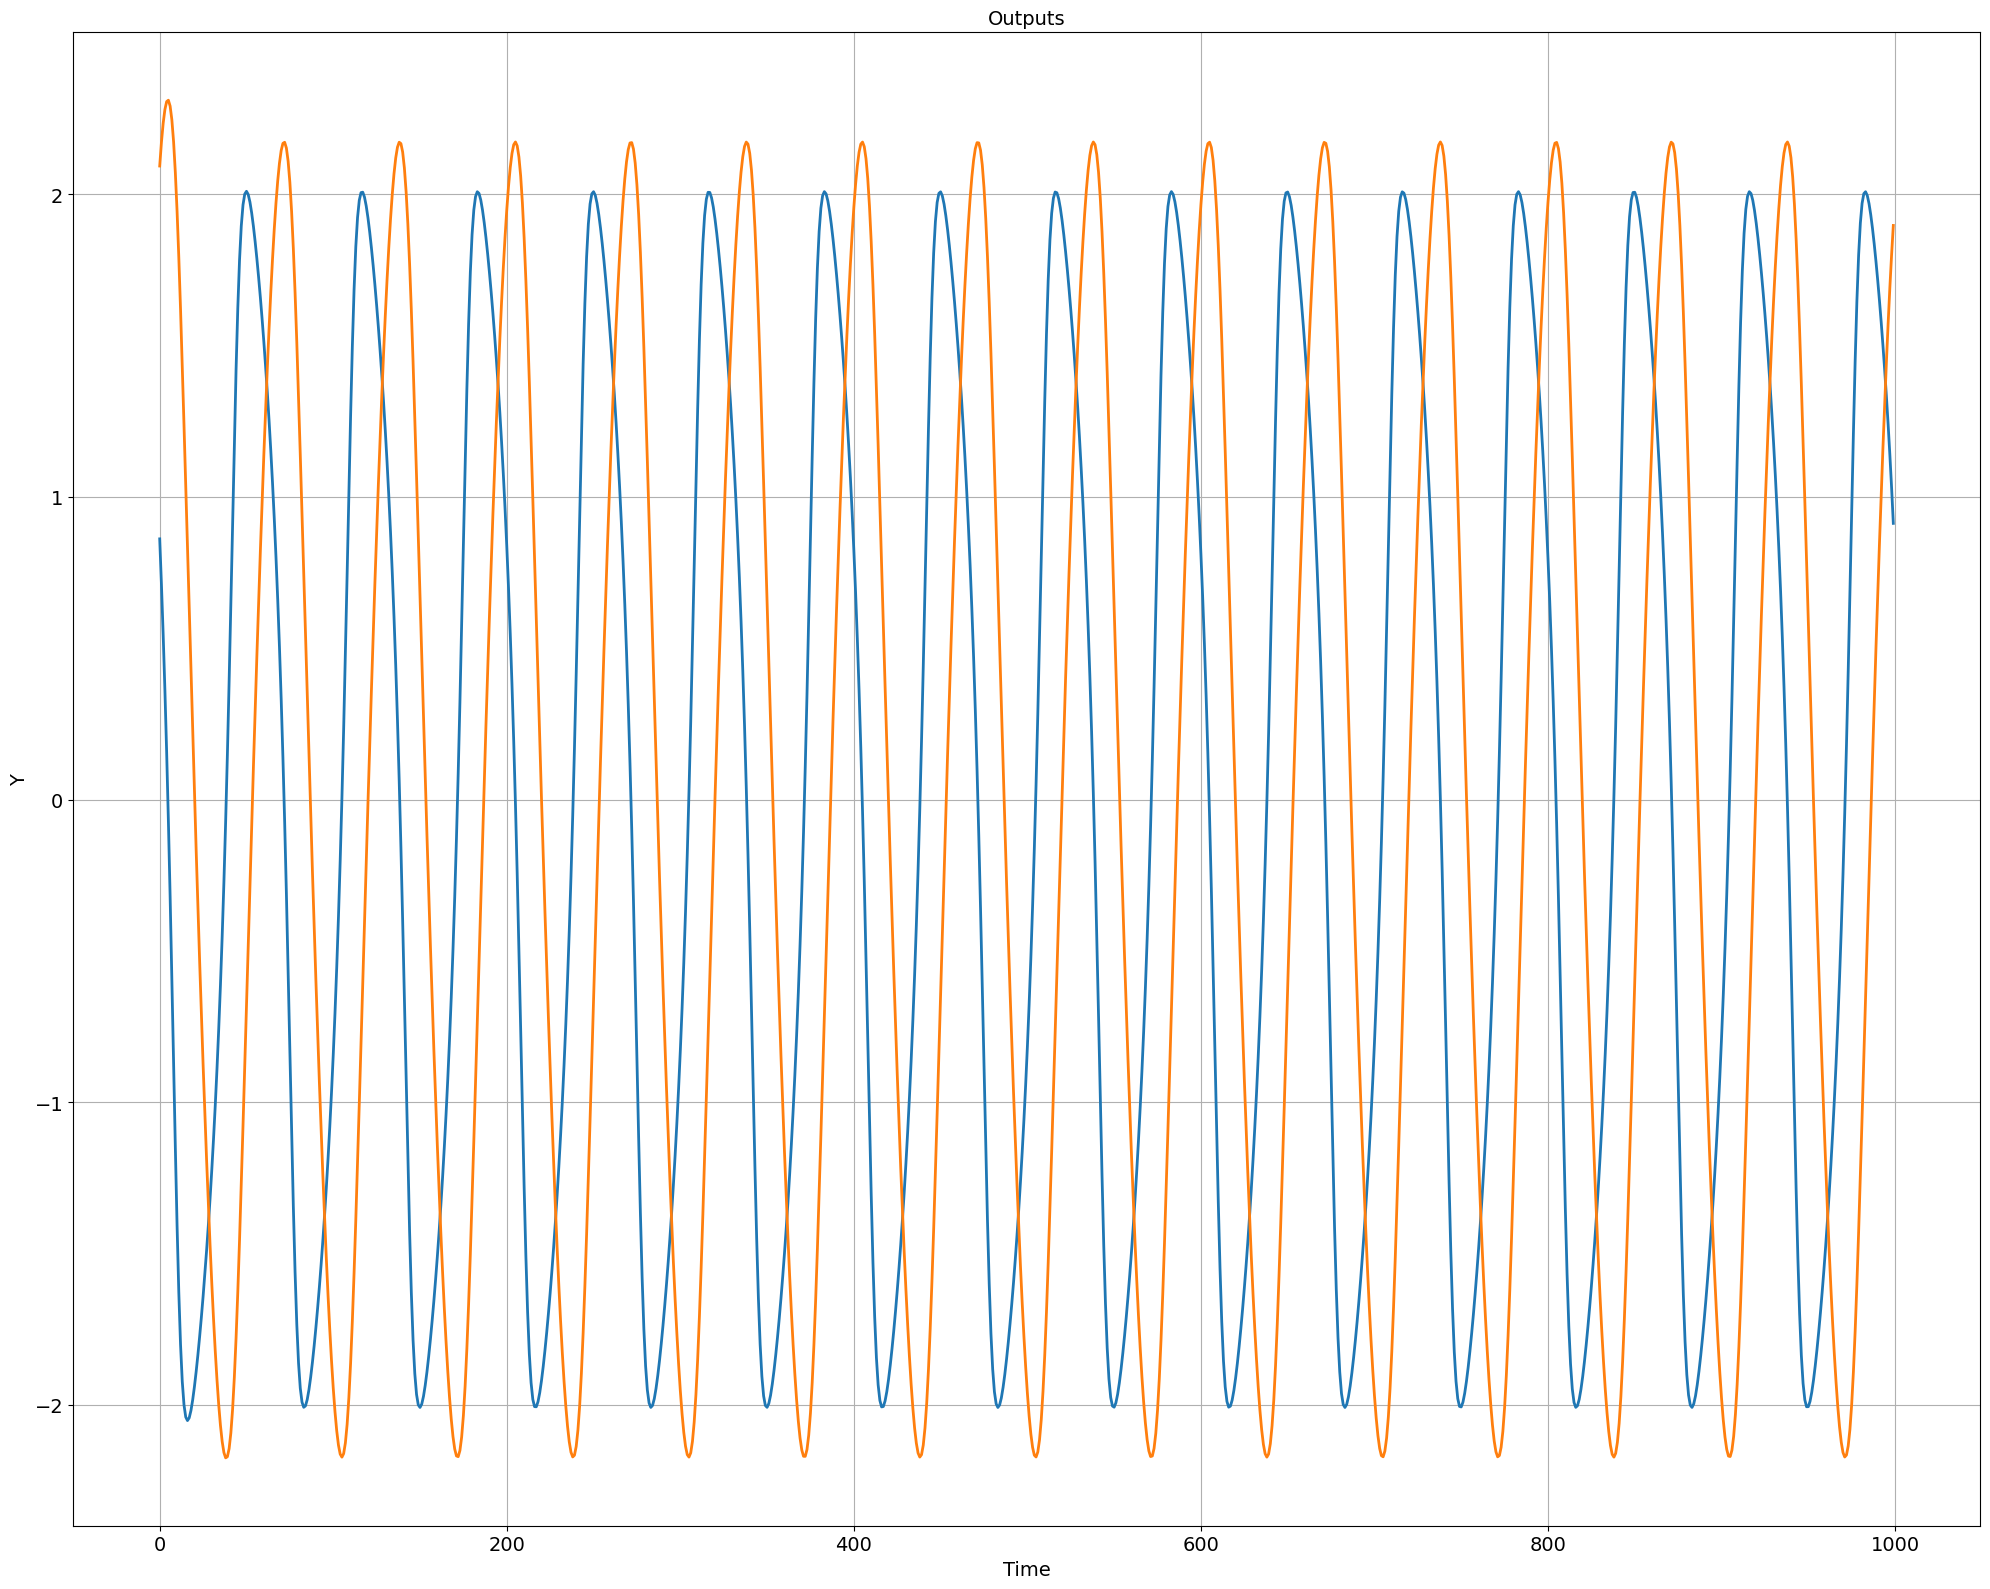

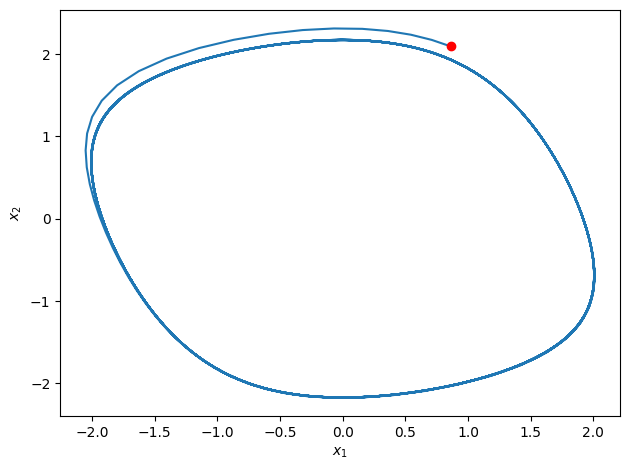

In [30]:
# %%  ground truth system
system = psl.systems['VanDerPol']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
ny = modelSystem.ny
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'])
plot.pltPhase(X=raw['Y'])

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics to model: 
$$\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.


In [31]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    ny = sys.ny
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainY = train_sim['Y'][:length].reshape(nbatch, nsteps, ny)
    trainY = torch.tensor(trainY, dtype=torch.float32)
    train_data = DictDataset({'Y': trainY, 'Y0': trainY[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devY = dev_sim['Y'][:length].reshape(nbatch, nsteps, ny)
    devY = torch.tensor(devY, dtype=torch.float32)
    dev_data = DictDataset({'Y': devY, 'Y0': devY[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testY = test_sim['Y'][:length].reshape(1, nsim, ny)
    testY = torch.tensor(testY, dtype=torch.float32)
    test_data = {'Y': testY, 'Y0': testY[:, 0:1, :], 'name': 'test'}

    return train_loader, dev_loader, test_data


In [32]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 20   # number of prediction horizon steps in the loss function
bs = 100      # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

## Deep Koopman model in Neuromancer

Here we construct a discrete-time encoder-decoder Koopman model:   

<img src="../figs/Koopman.PNG" width="500">  

Encoder: $${x}_{k} = \phi_{\theta_1}(y_k)$$ 
Koopman: $${x}_{k+1} = K_{\theta_2}(x_k)$$ 
Decoder: $$\hat{y}_{k+1} = \phi^{-1}_{\theta_3}(x_{k+1})$$  

with trainable parameters $\theta = \{\theta_1, \theta_2, \theta_3 \}$.

Please note the notation ($x$ and $y$) in the equation form is flipped from the notation in the image above.

In [33]:
# model parameters
nx_koopman = 50
n_hidden = 60
n_layers = 2

**Encoder and Decoder networks:**  Both encoder $\phi$ and decoder $\phi^{-1}$ are parametrized by two deep neural networks.

In [34]:
# instantiate encoder neural net
encode = blocks.MLP(ny, nx_koopman, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ELU,
                 hsizes=n_layers*[n_hidden])
# initial condition encoder: output of which to be used to initialize the Koopman operator rollout
encode_Y0 = Node(encode, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder: output of which to be used in latent trajectory prediction loss
encode_Y = Node(encode, ['Y'], ['x_traj'], name='encoder_Y')

In [35]:
# instantiate decoder neural net
decode = blocks.MLP(nx_koopman, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ELU,
                hsizes=n_layers*[n_hidden])
# reconstruction decoder: output of which to be used in encoder-decoder reconstruction loss
decode_y0 = Node(decode, ['x'], ['yhat0'], name='decoder_y0')
# predicted trajectory decoder: output of which to be used in output trajectory prediction loss
decode_y = Node(decode, ['x'], ['yhat'], name='decoder_y')

**Standard Koopman Operator** without stability guarantees is parametrized by linear layer of the latent size. 

**Stable Koopman Operator:**  For provably stable Koopman operator we can choose a range of linear algebra factorization that allow to constrain the eigenvalues of the resulting linear operator. 
In this example we use the following [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) factorization of the operator given as:
$$K = U \Sigma V$$ 
$$\Sigma =  \text{diag}(\lambda_{\text{max}} - (\lambda_{\text{max}} - \lambda_{\text{min}}) \cdot \sigma(\Lambda)) $$
where $\sigma$ is logistic sigmoid activation function, $\cdot$ is a dot product, $\Lambda$ is a vector of eigenvalues of the linear operator, while $\lambda_{\text{max}}$ and $\lambda_{\text{min}}$ are constraints on maximum and minimum value of SVD factorized linear operator.

<img src="../figs/SVD_layer.png" width="300">  

In order for the SVD factorization to hold the left and right matrices $U$ and $V$, respectively, needs to be [orthogonal](https://en.wikipedia.org/wiki/Orthogonal_matrix).
This can be achieved either via [Householder reflectors](https://arxiv.org/abs/1803.09327), or via penalties in the loss function given as:  
$$\ell_{U} = || I - UU^T||_2 + || I - U^TU||_2  $$
$$\ell_{V} = || I - VV^T||_2 + || I - V^TV||_2  $$
$$\ell_{\text{stable}} = \ell_{U} + \ell_{V} $$

For more details on the SVD and other linear algebra factorizations of trainable linear layers see the references [[8]](https://ieeexplore.ieee.org/document/9482930) and [[9]](https://ieeexplore.ieee.org/abstract/document/9809789), with Pytorch implementations in the [slim submodule](https://github.com/pnnl/neuromancer/tree/master/src/neuromancer/slim) of the Neuromancer library. 

In [36]:
# instantiate Koopman operator matrix
stable = True     # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(nx_koopman, nx_koopman,
                          sigma_min=0.01, sigma_max=1.0, bias=False)
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.*(K_reg_error == 0.0)
    K_reg_loss.name = 'SVD_loss'
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)

In [37]:
# symbolic Koopman model
Koopman = Node(K, ['x'], ['x'], name='K')

# latent Koopmann rollout over nsteps long prediction horizon
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [38]:
# dynamics_model.show()

In [46]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, decode_y0, encode_Y, dynamics_model, decode_y]

## Define Koopman system identification loss function terms

Here we define loss function terms to fit the encoded-decoder Koopman parameters $\theta$ from given time-series data.
The loss function terms follow the implementation as given in the reference [[2]](https://www.nature.com/articles/s41467-018-07210-0). 

**Output trajectory prediction loss:**  
$$\ell_y = \sum_{k=1}^{N} Q_y||y^i_{k+1} - \hat{y}^i_{k+1}||_2^2$$ 
**One step output prediction loss:**  
$$\ell_{y_1} = Q_{y_1}||y^i_2 - \hat{y}^i_2||_2^2$$ 

where $\hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y^i_1))) $, 
and $N$ is defining length of the rollout (prediction) horizon.  

**Latent trajectory prediction loss:**  
$$\ell_{\text{lin}} = \sum_{k=1}^{N}  Q_x||\phi_{\theta_1}(y_{k+1}^i) - K^k\phi_{\theta_1}(y_1^i)||_2^2$$ 
**Reconstruction loss:**  
$$\ell_{\text{recon}} = Q_{\text{recon}}||y^i_1 - \phi^{-1}_{\theta_3}(\phi_{\theta_1}(y_1^i))||_2^2$$ 


$\ell_{\text{recon}}$ effectively acts as soft constraint on the deconder inverse to be equal to the encoder network. 

In [47]:
# %% Constraints + losses:
Y = variable("Y")                      # observed outputs from the dataset
Y0 = variable('Y0')                    # observed initial conditions from the dataset
yhat = variable('yhat')                # predicted output by the encoder-decoder Koopman operator
yhat0 = variable('yhat0')              # reconstructed initial conditions by the encoder-decoder
x_traj = variable('x_traj')            # encoded trajectory in the latent space: \phi_{\theta_1}(y_{k+1}) 
x = variable('x')                      # Koopman latent space trajectory: K^k\phi_{\theta_1}(y_1)

# output trajectory prediction loss
y_loss = 10.*(yhat[:, 1:-1, :] == Y[:, 1:, :])^2
y_loss.name = "y_loss"

# one-step  output prediction loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# latent trajectory prediction loss
x_loss = 1.*(x[:, 1:-1, :] == x_traj[:, 1:, :])^2
x_loss.name = "x_loss"

# encoder-decoder reconstruction loss
reconstruct_loss = 1.*(Y0 == yhat0)^2
reconstruct_loss.name = "reconstruct_loss"

## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big( \ell_{y} + \ell_{y_1}  +\ell_{\text{lin}} + \ell_{\text{recon}} + \ell_{\text{stable}} \Big) \\
&\text{subject to}    && \hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y_1^i))) \\
\end{align}
$$  

In [48]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruct_loss]
if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [49]:
# plot computational graph
# problem.show()

## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

In [50]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=100,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)


None
Number of parameters: 18833


In [51]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0	train_loss: 26.32224	dev_loss: 26.13415	eltime:  1.11019
epoch: 1	train_loss: 26.13415	dev_loss: 25.95629	eltime:  1.14974
epoch: 2	train_loss: 25.95629	dev_loss: 25.77995	eltime:  1.19663
epoch: 3	train_loss: 25.77995	dev_loss: 25.59616	eltime:  1.24359
epoch: 4	train_loss: 25.59616	dev_loss: 25.39720	eltime:  1.29230
epoch: 5	train_loss: 25.39720	dev_loss: 25.17434	eltime:  1.34341
epoch: 6	train_loss: 25.17435	dev_loss: 24.92078	eltime:  1.39411
epoch: 7	train_loss: 24.92078	dev_loss: 24.63028	eltime:  1.44545
epoch: 8	train_loss: 24.63028	dev_loss: 24.29714	eltime:  1.48627
epoch: 9	train_loss: 24.29714	dev_loss: 23.91705	eltime:  1.53724
epoch: 10	train_loss: 23.91705	dev_loss: 23.48718	eltime:  1.58881
epoch: 11	train_loss: 23.48718	dev_loss: 23.00627	eltime:  1.64540
epoch: 12	train_loss: 23.00627	dev_loss: 22.47607	eltime:  1.69615
epoch: 13	train_loss: 22.47607	dev_loss: 21.90202	eltime:  1.74520
epoch: 14	train_loss: 21.90202	dev_loss: 21.29256	eltime:  1.78791
epoch

epoch: 126	train_loss: 0.19371	dev_loss: 0.19173	eltime:  7.96371
epoch: 127	train_loss: 0.19173	dev_loss: 0.18953	eltime:  8.01861
epoch: 128	train_loss: 0.18953	dev_loss: 0.18738	eltime:  8.06171
epoch: 129	train_loss: 0.18738	dev_loss: 0.18521	eltime:  8.11261
epoch: 130	train_loss: 0.18521	dev_loss: 0.18318	eltime:  8.16365
epoch: 131	train_loss: 0.18318	dev_loss: 0.18116	eltime:  8.21260
epoch: 132	train_loss: 0.18116	dev_loss: 0.17910	eltime:  8.26372
epoch: 133	train_loss: 0.17910	dev_loss: 0.17708	eltime:  8.31465
epoch: 134	train_loss: 0.17708	dev_loss: 0.17509	eltime:  8.36550
epoch: 135	train_loss: 0.17509	dev_loss: 0.17309	eltime:  8.41432
epoch: 136	train_loss: 0.17309	dev_loss: 0.17123	eltime:  8.46755
epoch: 137	train_loss: 0.17123	dev_loss: 0.16932	eltime:  8.52163
epoch: 138	train_loss: 0.16932	dev_loss: 0.16729	eltime:  8.57117
epoch: 139	train_loss: 0.16729	dev_loss: 0.16553	eltime:  8.62023
epoch: 140	train_loss: 0.16553	dev_loss: 0.16373	eltime:  8.67110
epoch: 141

epoch: 250	train_loss: 0.04257	dev_loss: 0.04189	eltime:  14.64942
epoch: 251	train_loss: 0.04189	dev_loss: 0.04149	eltime:  14.70543
epoch: 252	train_loss: 0.04149	dev_loss: 0.04106	eltime:  14.75843
epoch: 253	train_loss: 0.04106	dev_loss: 0.04052	eltime:  14.82044
epoch: 254	train_loss: 0.04052	dev_loss: 0.03990	eltime:  14.87940
epoch: 255	train_loss: 0.03990	dev_loss: 0.03925	eltime:  14.93537
epoch: 256	train_loss: 0.03925	dev_loss: 0.03882	eltime:  14.98937
epoch: 257	train_loss: 0.03882	dev_loss: 0.03829	eltime:  15.04443
epoch: 258	train_loss: 0.03829	dev_loss: 0.03777	eltime:  15.09838
epoch: 259	train_loss: 0.03777	dev_loss: 0.03730	eltime:  15.15443
epoch: 260	train_loss: 0.03730	dev_loss: 0.03678	eltime:  15.21037
epoch: 261	train_loss: 0.03678	dev_loss: 0.03629	eltime:  15.26737
epoch: 262	train_loss: 0.03629	dev_loss: 0.03593	eltime:  15.32137
epoch: 263	train_loss: 0.03593	dev_loss: 0.03548	eltime:  15.38138
epoch: 264	train_loss: 0.03548	dev_loss: 0.03493	eltime:  15.4

epoch: 375	train_loss: 0.00959	dev_loss: 0.00946	eltime:  21.60714
epoch: 376	train_loss: 0.00946	dev_loss: 0.00923	eltime:  21.66569
epoch: 377	train_loss: 0.00923	dev_loss: 0.00927	eltime:  21.72169
epoch: 378	train_loss: 0.00927	dev_loss: 0.00928	eltime:  21.78469
epoch: 379	train_loss: 0.00928	dev_loss: 0.00918	eltime:  21.85969
epoch: 380	train_loss: 0.00918	dev_loss: 0.00898	eltime:  21.91569
epoch: 381	train_loss: 0.00898	dev_loss: 0.00876	eltime:  21.97035
epoch: 382	train_loss: 0.00876	dev_loss: 0.00875	eltime:  22.02336
epoch: 383	train_loss: 0.00875	dev_loss: 0.00864	eltime:  22.07736
epoch: 384	train_loss: 0.00864	dev_loss: 0.00852	eltime:  22.13336
epoch: 385	train_loss: 0.00852	dev_loss: 0.00845	eltime:  22.19636
epoch: 386	train_loss: 0.00845	dev_loss: 0.00834	eltime:  22.26035
epoch: 387	train_loss: 0.00834	dev_loss: 0.00823	eltime:  22.32136
epoch: 388	train_loss: 0.00823	dev_loss: 0.00827	eltime:  22.38036
epoch: 389	train_loss: 0.00827	dev_loss: 0.00820	eltime:  22.4

epoch: 498	train_loss: 0.00404	dev_loss: 0.00393	eltime:  28.22513
epoch: 499	train_loss: 0.00393	dev_loss: 0.00404	eltime:  28.27657
epoch: 500	train_loss: 0.00404	dev_loss: 0.00409	eltime:  28.32532
epoch: 501	train_loss: 0.00409	dev_loss: 0.00403	eltime:  28.36888
epoch: 502	train_loss: 0.00403	dev_loss: 0.00388	eltime:  28.42823
epoch: 503	train_loss: 0.00388	dev_loss: 0.00401	eltime:  28.48125
epoch: 504	train_loss: 0.00401	dev_loss: 0.00409	eltime:  28.53226
epoch: 505	train_loss: 0.00409	dev_loss: 0.00407	eltime:  28.58162
epoch: 506	train_loss: 0.00407	dev_loss: 0.00395	eltime:  28.62493
epoch: 507	train_loss: 0.00395	dev_loss: 0.00380	eltime:  28.67631
epoch: 508	train_loss: 0.00380	dev_loss: 0.00387	eltime:  28.72738
epoch: 509	train_loss: 0.00387	dev_loss: 0.00382	eltime:  28.76816
epoch: 510	train_loss: 0.00382	dev_loss: 0.00378	eltime:  28.81936
epoch: 511	train_loss: 0.00378	dev_loss: 0.00378	eltime:  28.87040
epoch: 512	train_loss: 0.00378	dev_loss: 0.00373	eltime:  28.9

epoch: 622	train_loss: 0.00278	dev_loss: 0.00289	eltime:  34.91185
epoch: 623	train_loss: 0.00289	dev_loss: 0.00289	eltime:  34.97185
epoch: 624	train_loss: 0.00289	dev_loss: 0.00279	eltime:  35.02886
epoch: 625	train_loss: 0.00279	dev_loss: 0.00291	eltime:  35.07686
epoch: 626	train_loss: 0.00291	dev_loss: 0.00297	eltime:  35.12193
epoch: 627	train_loss: 0.00297	dev_loss: 0.00292	eltime:  35.17286
epoch: 628	train_loss: 0.00292	dev_loss: 0.00278	eltime:  35.23085
epoch: 629	train_loss: 0.00278	dev_loss: 0.00291	eltime:  35.28391
epoch: 630	train_loss: 0.00291	dev_loss: 0.00301	eltime:  35.33485
epoch: 631	train_loss: 0.00301	dev_loss: 0.00299	eltime:  35.38785
epoch: 632	train_loss: 0.00299	dev_loss: 0.00288	eltime:  35.44493
epoch: 633	train_loss: 0.00288	dev_loss: 0.00274	eltime:  35.50185
epoch: 634	train_loss: 0.00274	dev_loss: 0.00281	eltime:  35.55890
epoch: 635	train_loss: 0.00281	dev_loss: 0.00277	eltime:  35.61285
epoch: 636	train_loss: 0.00277	dev_loss: 0.00274	eltime:  35.6

epoch: 746	train_loss: 0.00223	dev_loss: 0.00219	eltime:  41.20991
epoch: 747	train_loss: 0.00219	dev_loss: 0.00216	eltime:  41.26100
epoch: 748	train_loss: 0.00216	dev_loss: 0.00227	eltime:  41.30218
epoch: 749	train_loss: 0.00227	dev_loss: 0.00227	eltime:  41.34344
epoch: 750	train_loss: 0.00227	dev_loss: 0.00217	eltime:  41.39463
epoch: 751	train_loss: 0.00217	dev_loss: 0.00229	eltime:  41.44587
epoch: 752	train_loss: 0.00229	dev_loss: 0.00236	eltime:  41.49497
epoch: 753	train_loss: 0.00236	dev_loss: 0.00231	eltime:  41.53785
epoch: 754	train_loss: 0.00231	dev_loss: 0.00217	eltime:  41.58904
epoch: 755	train_loss: 0.00217	dev_loss: 0.00231	eltime:  41.64026
epoch: 756	train_loss: 0.00231	dev_loss: 0.00240	eltime:  41.69100
epoch: 757	train_loss: 0.00240	dev_loss: 0.00239	eltime:  41.74993
epoch: 758	train_loss: 0.00239	dev_loss: 0.00228	eltime:  41.79302
epoch: 759	train_loss: 0.00228	dev_loss: 0.00214	eltime:  41.86220
epoch: 760	train_loss: 0.00214	dev_loss: 0.00221	eltime:  41.9

epoch: 872	train_loss: 0.00178	dev_loss: 0.00174	eltime:  47.82910
epoch: 873	train_loss: 0.00174	dev_loss: 0.00172	eltime:  47.89197
epoch: 874	train_loss: 0.00172	dev_loss: 0.00183	eltime:  47.94985
epoch: 875	train_loss: 0.00183	dev_loss: 0.00183	eltime:  48.00777
epoch: 876	train_loss: 0.00183	dev_loss: 0.00173	eltime:  48.06466
epoch: 877	train_loss: 0.00173	dev_loss: 0.00186	eltime:  48.12125
epoch: 878	train_loss: 0.00186	dev_loss: 0.00192	eltime:  48.17212
epoch: 879	train_loss: 0.00192	dev_loss: 0.00187	eltime:  48.22272
epoch: 880	train_loss: 0.00187	dev_loss: 0.00173	eltime:  48.27355
epoch: 881	train_loss: 0.00173	dev_loss: 0.00187	eltime:  48.33242
epoch: 882	train_loss: 0.00187	dev_loss: 0.00197	eltime:  48.38516
epoch: 883	train_loss: 0.00197	dev_loss: 0.00196	eltime:  48.43559
epoch: 884	train_loss: 0.00196	dev_loss: 0.00185	eltime:  48.48746
epoch: 885	train_loss: 0.00185	dev_loss: 0.00171	eltime:  48.54838
epoch: 886	train_loss: 0.00171	dev_loss: 0.00179	eltime:  48.6

<All keys matched successfully>

## System Identification results

In [52]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [53]:
# Test set results
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, nx).T
true_traj = test_data['Y'][:, 1:, :].detach().numpy().reshape(-1, nx).T

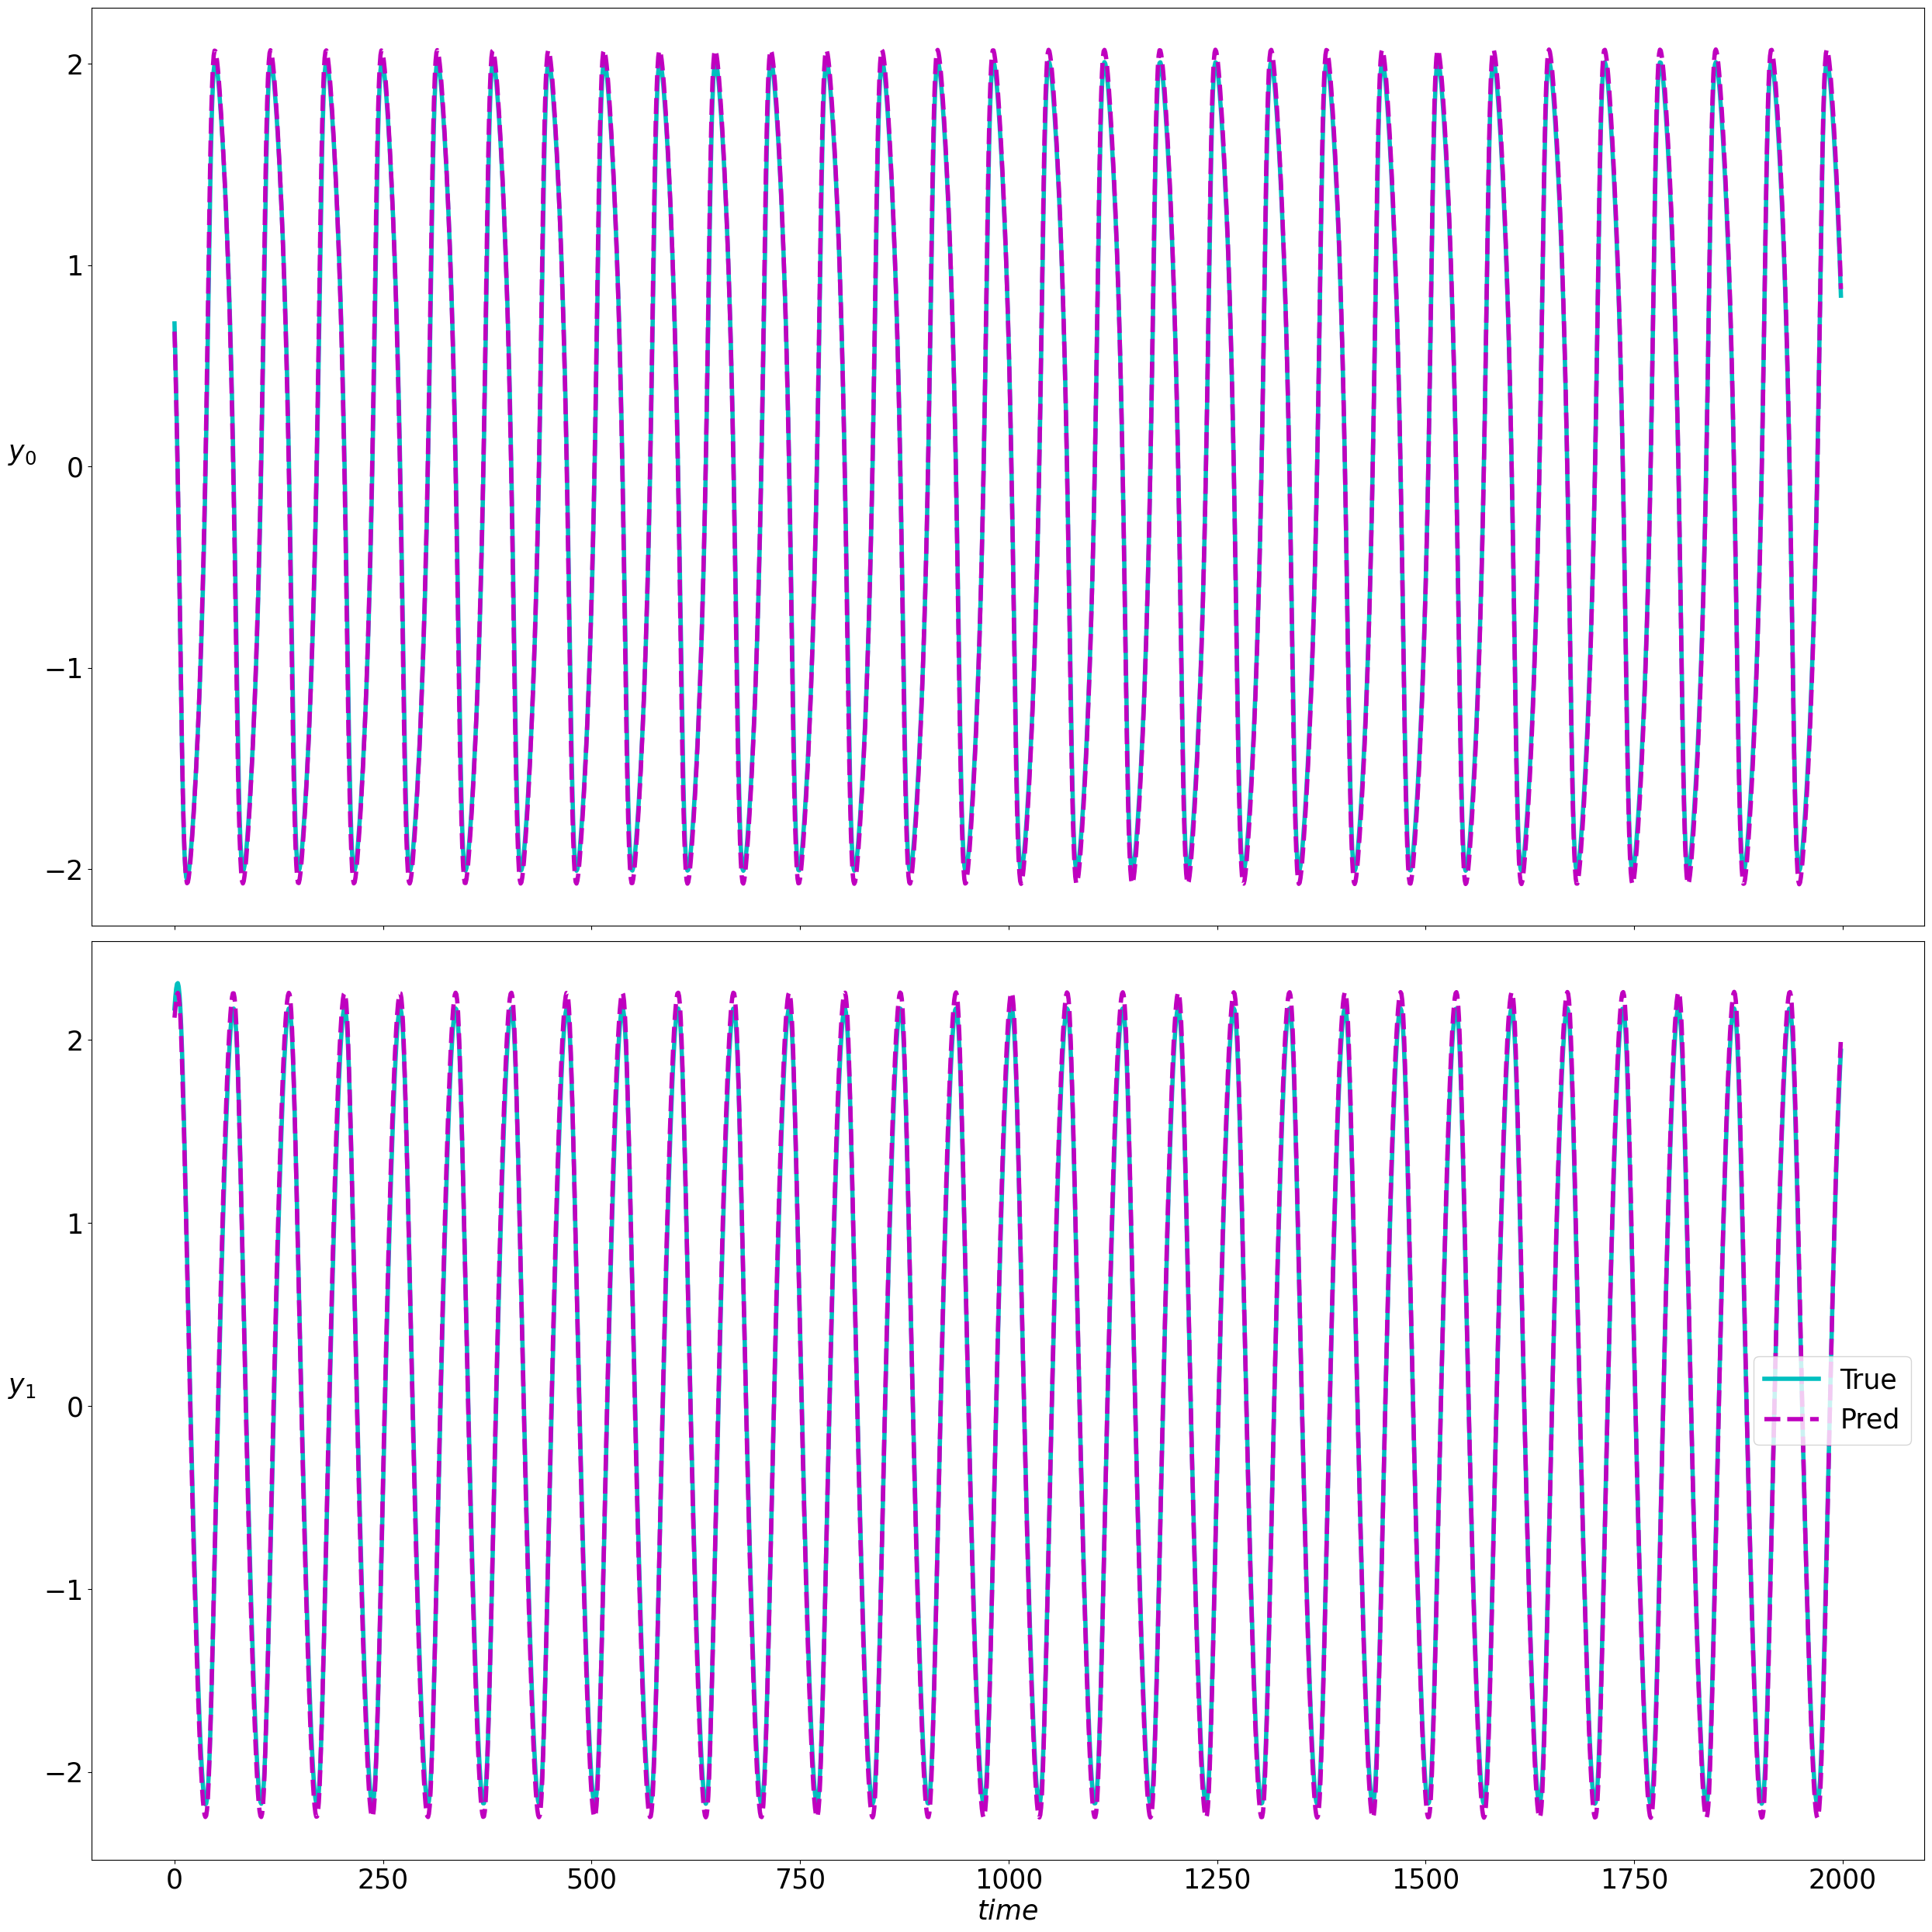

In [54]:
# plot trajectories
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

In [55]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eReal = eig.real.detach().numpy()
eImag = eig.imag.detach().numpy()
# unit circle
t = np.linspace(0.0, 2 * np.pi, 1000)
x_circ = np.cos(t)
y_circ = np.sin(t)


Text(0.5, 0.98, 'Koopman operator eigenvalues')

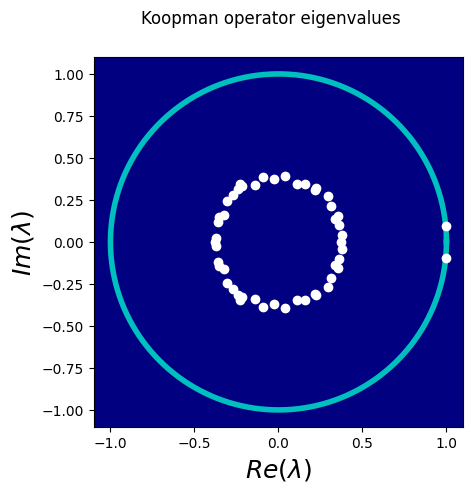

In [66]:
# plot Koopman eigenvalues
fig1, ax1 = plt.subplots()
ax1.plot(x_circ, y_circ, 'c', linewidth=4)
ax1.plot(eReal, eImag, 'wo')
ax1.set_aspect('equal', 'box')
ax1.set_facecolor("navy")
ax1.set_xlabel("$Re(\lambda)$", fontsize=18)
ax1.set_ylabel("$Im(\lambda)$", fontsize=18)
fig1.suptitle('Koopman operator eigenvalues')


In [57]:
# compute Koopman eigenvectors
y1 = torch.linspace(-2.2, 2.2, 1000)
y2 = torch.linspace(-2.2, 2.2, 1000)
yy1, yy2 = torch.meshgrid(y1, y1)
plot_yy1 = yy1.detach().numpy()
plot_yy2 = yy2.detach().numpy()
# eigenvectors
features = torch.stack([yy1, yy2]).transpose(0, 2)
latent = encode(features)
phi = torch.matmul(latent, abs(eig_vec))
# select first 6 eigenvectors
phi_1 = phi.detach().numpy()[:,:,0]
phi_2 = phi.detach().numpy()[:,:,1]
phi_3 = phi.detach().numpy()[:,:,2]
phi_4 = phi.detach().numpy()[:,:,3]
phi_5 = phi.detach().numpy()[:,:,4]
phi_6 = phi.detach().numpy()[:,:,6]


C:\Users\drgo694\OneDrive - PNNL\Documents\anaconda3\envs\neuromancer\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 0.98, 'first six eigenfunctions')

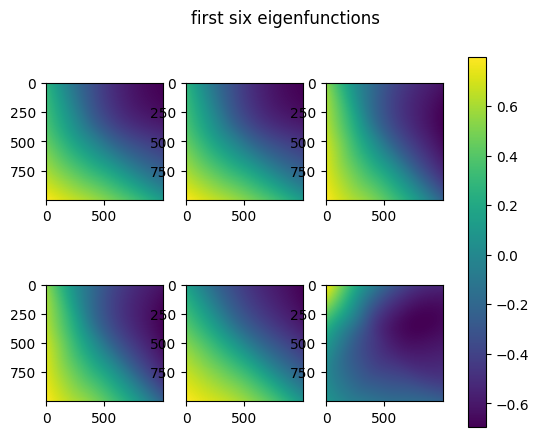

In [64]:
# plot eigenvectors
fig2, axs = plt.subplots(2, 3)
im1 = axs[0,0].imshow(phi_1)
im2 = axs[0,1].imshow(phi_2)
im3 = axs[0,2].imshow(phi_3)
im4 = axs[1,0].imshow(phi_4)
im5 = axs[1,1].imshow(phi_5)
im6 = axs[1,2].imshow(phi_6)
fig2.colorbar(im1, ax=axs)
fig2.suptitle('first six eigenfunctions')
